<a href="https://colab.research.google.com/github/alexisgutierrezpy/AML-Final-Gutierrez-Alexis/blob/main/notebooks/Alexis_Gutierrez_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Modelos de Machine Learning y Deep Learning
## Predicción de Precios Bursátiles con Datos de Yahoo Finance

| | |
|---|---|
| **Estudiante** | Alexis Gutierrez |
| **Curso** | Advanced Machine Learning |
| **Fecha** | Febrero 2026 |
| **Dataset** | Yahoo Finance API (yfinance) |
| **Modelos** | LSTM · Transformer |
| **Framework** | PyTorch |

---
## 1. 📝 Resumen Ejecutivo

Este proyecto aplica técnicas de Deep Learning para predecir el precio de cierre de acciones (Apple Inc. - AAPL) utilizando datos históricos reales obtenidos a través de la API de Yahoo Finance (`yfinance`). Se implementan y comparan dos arquitecturas de redes neuronales:

1. **LSTM (Long Short-Term Memory):** Red neuronal recurrente especializada en capturar dependencias temporales de corto y mediano plazo en series de tiempo.
2. **Transformer (Temporal):** Arquitectura basada en mecanismos de auto-atención, capaz de modelar dependencias de largo alcance en secuencias temporales.

**Objetivo principal:** Predecir el precio de cierre del día siguiente a partir de una ventana de 60 días históricos.

**Hipótesis:** Los patrones temporales en precios históricos, volumen e indicadores técnicos contienen señales predictivas que los modelos de DL pueden aprender mejor que enfoques estadísticos clásicos.

---
## 2. Configuración del Entorno

In [ ]:
# ── Instalación de dependencias ──────────────────────────────────────────────
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn torch torchvision -q

In [ ]:
# ── Verificación de GPU ──────────────────────────────────────────────────────
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo disponible: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    print('No se detectó GPU. El entrenamiento se realizará en CPU.')

Dispositivo disponible: cuda
GPU: Tesla T4
Memoria GPU: 15.6 GB


In [ ]:
# ── Importaciones principales ────────────────────────────────────────────────
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Estilo de gráficas
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print('✅ Librerías cargadas correctamente')
print(f'   PyTorch version : {torch.__version__}')
print(f'   yfinance version: {yf.__version__}')
print(f'   pandas version  : {pd.__version__}')

✅ Librerías cargadas correctamente
   PyTorch version : 2.10.0+cu128
   yfinance version: 0.2.66
   pandas version  : 2.2.2


---
## 3. 🎯 Definición del Problema de Negocio

### 3.1 Contexto
Los mercados financieros generan miles de millones de datos diariamente. La capacidad de predecir movimientos de precios con mayor precisión tiene implicaciones directas para:
- Gestión de portafolios de inversión
- Estrategias de trading algorítmico
- Gestión de riesgo financiero
- Toma de decisiones institucionales

### 3.2 Formulación del Problema
**Tipo:** Regresión de series de tiempo  
**Variable objetivo (Y):** Precio de cierre ajustado del día t+1  
**Variables predictoras (X):** Ventana de 60 días de: Open, High, Low, Close, Volume + indicadores técnicos  
**Acción:** Apple Inc. (AAPL) — NYSE  
**Período:** 2015-01-01 a 2024-12-31  

### 3.3 Métricas de Éxito
| Métrica | Descripción | Objetivo |
|---------|-------------|----------|
| RMSE | Error cuadrático medio | < 5% del precio promedio |
| MAE | Error absoluto medio | Minimizar |
| R² | Coeficiente de determinación | > 0.85 |
| MAPE | Error porcentual absoluto medio | < 3% |

---
## 4. 📥 Carga de Datos y EDA

In [ ]:
# ── Descarga de datos desde Yahoo Finance ────────────────────────────────────
TICKER   = 'AAPL'
START    = '2015-01-01'
END      = '2024-12-31'

print(f'📡 Descargando datos de {TICKER} ({START} → {END})...')
ticker_obj = yf.Ticker(TICKER)

# Precios históricos OHLCV
df = ticker_obj.history(start=START, end=END, auto_adjust=True)
df.index = pd.to_datetime(df.index).tz_localize(None)  # Eliminar timezone
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

print(f'✅ Datos descargados: {len(df)} registros')
print(f'   Período : {df.index.min().date()} → {df.index.max().date()}')
print(f'   Columnas: {list(df.columns)}')
df.head(10)

📡 Descargando datos de AAPL (2015-01-01 → 2024-12-31)...
✅ Datos descargados: 2515 registros
   Período : 2015-01-02 → 2024-12-30
   Columnas: ['Open', 'High', 'Low', 'Close', 'Volume']


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.671149,24.682224,23.776352,24.214891,212818400
2015-01-05,23.984551,24.064285,23.346676,23.532722,257142000
2015-01-06,23.596952,23.794073,23.173916,23.534937,263188400
2015-01-07,23.743129,23.964614,23.632387,23.864946,160423600
2015-01-08,24.192745,24.839479,24.075357,24.781893,237458000
2015-01-09,24.954651,25.083112,24.409799,24.808472,214798000
2015-01-12,24.939147,24.945791,24.097507,24.197174,198603200
2015-01-13,24.680008,24.983442,24.121868,24.412012,268367600
2015-01-14,24.150656,24.471808,24.031055,24.318985,195826400


In [ ]:
# ── Información general del dataset ──────────────────────────────────────────
print('=' * 60)
print('INFORMACIÓN DEL DATASET')
print('=' * 60)
print(f'Shape: {df.shape}')
print()
df.info()
print()
print('ESTADÍSTICAS DESCRIPTIVAS:')
df.describe().round(2)

INFORMACIÓN DEL DATASET
Shape: (2515, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Close   2515 non-null   float64
 4   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB

ESTADÍSTICAS DESCRIPTIVAS:


,Open,High,Low,Close,Volume
count,2515.00,2515.00,2515.00,2515.00,2.515000e+03
mean,93.62,94.62,92.70,93.71,1.171162e+08
std,65.24,65.91,64.63,65.32,6.839222e+07
min,20.51,20.89,20.39,20.58,2.323470e+07
25%,35.20,35.57,34.81,35.17,7.108655e+07
50%,64.07,64.66,63.51,64.31,1.003845e+08
75%,149.86,151.81,148.07,150.08,1.426222e+08
max,256.79,258.69,256.23,257.61,6.488252e+08


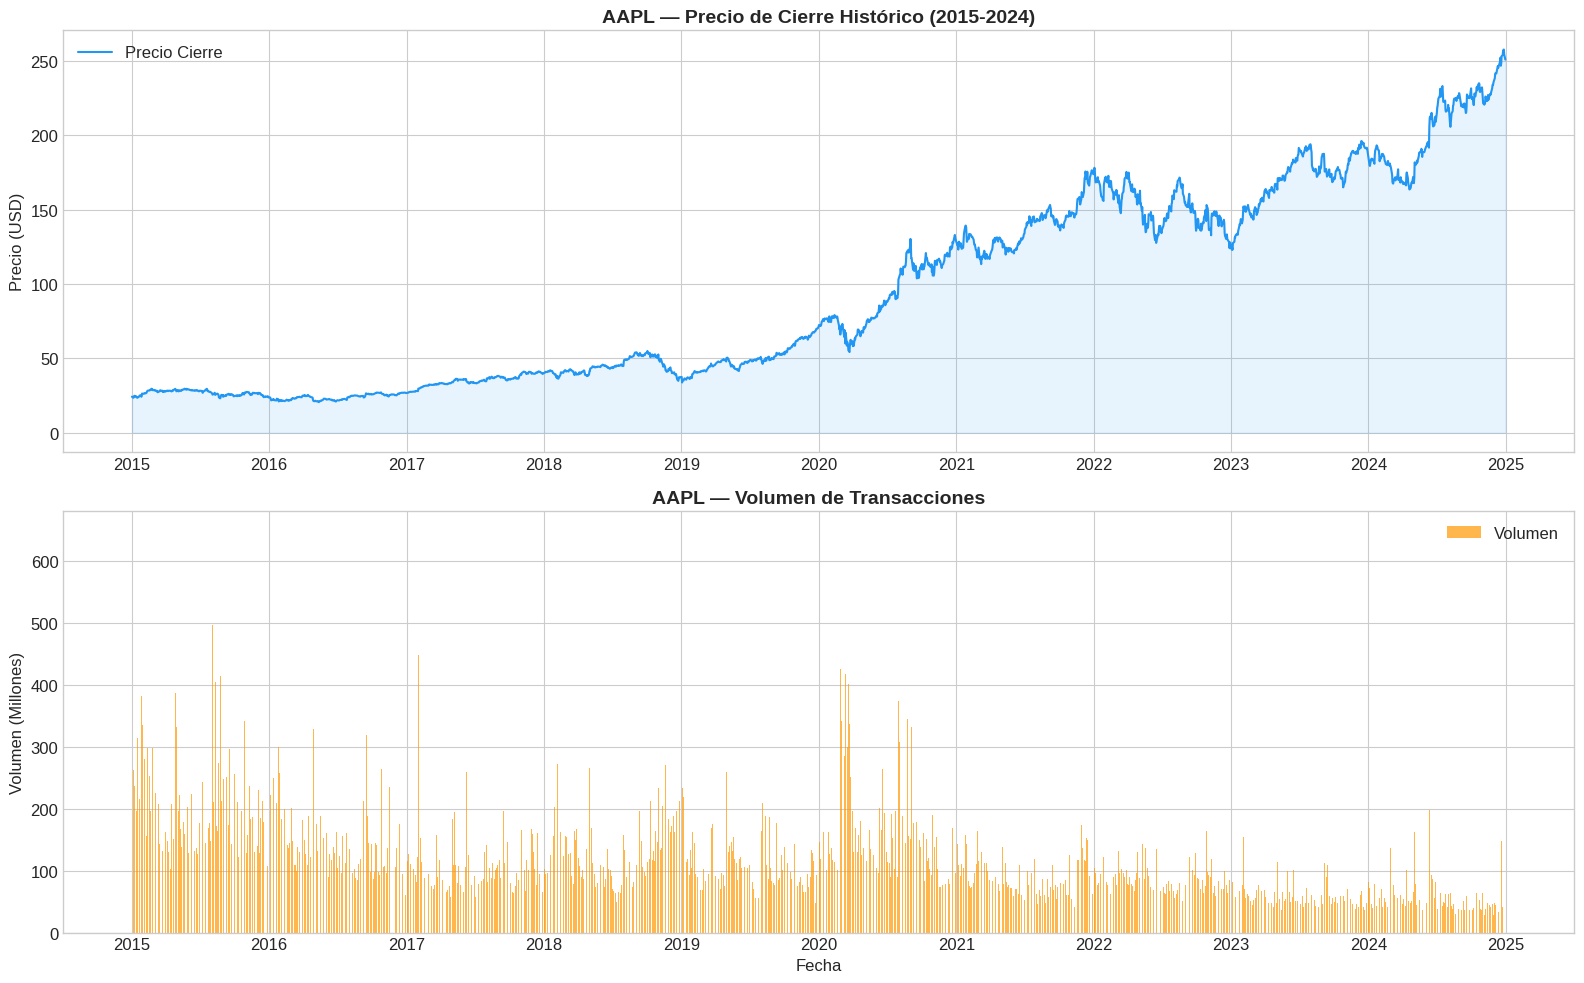

Figura guardada: eda_price_volume.png


In [ ]:
# ── EDA 1: Precio de cierre histórico ────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Precio de cierre
axes[0].plot(df.index, df['Close'], color='#2196F3', linewidth=1.5, label='Precio Cierre')
axes[0].fill_between(df.index, df['Close'], alpha=0.1, color='#2196F3')
axes[0].set_title(f'{TICKER} — Precio de Cierre Histórico (2015-2024)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend()
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Volumen
axes[1].bar(df.index, df['Volume'] / 1e6, color='#FF9800', alpha=0.7, label='Volumen')
axes[1].set_title(f'{TICKER} — Volumen de Transacciones', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volumen (Millones)')
axes[1].set_xlabel('Fecha')
axes[1].legend()
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('eda_price_volume.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figura guardada: eda_price_volume.png')

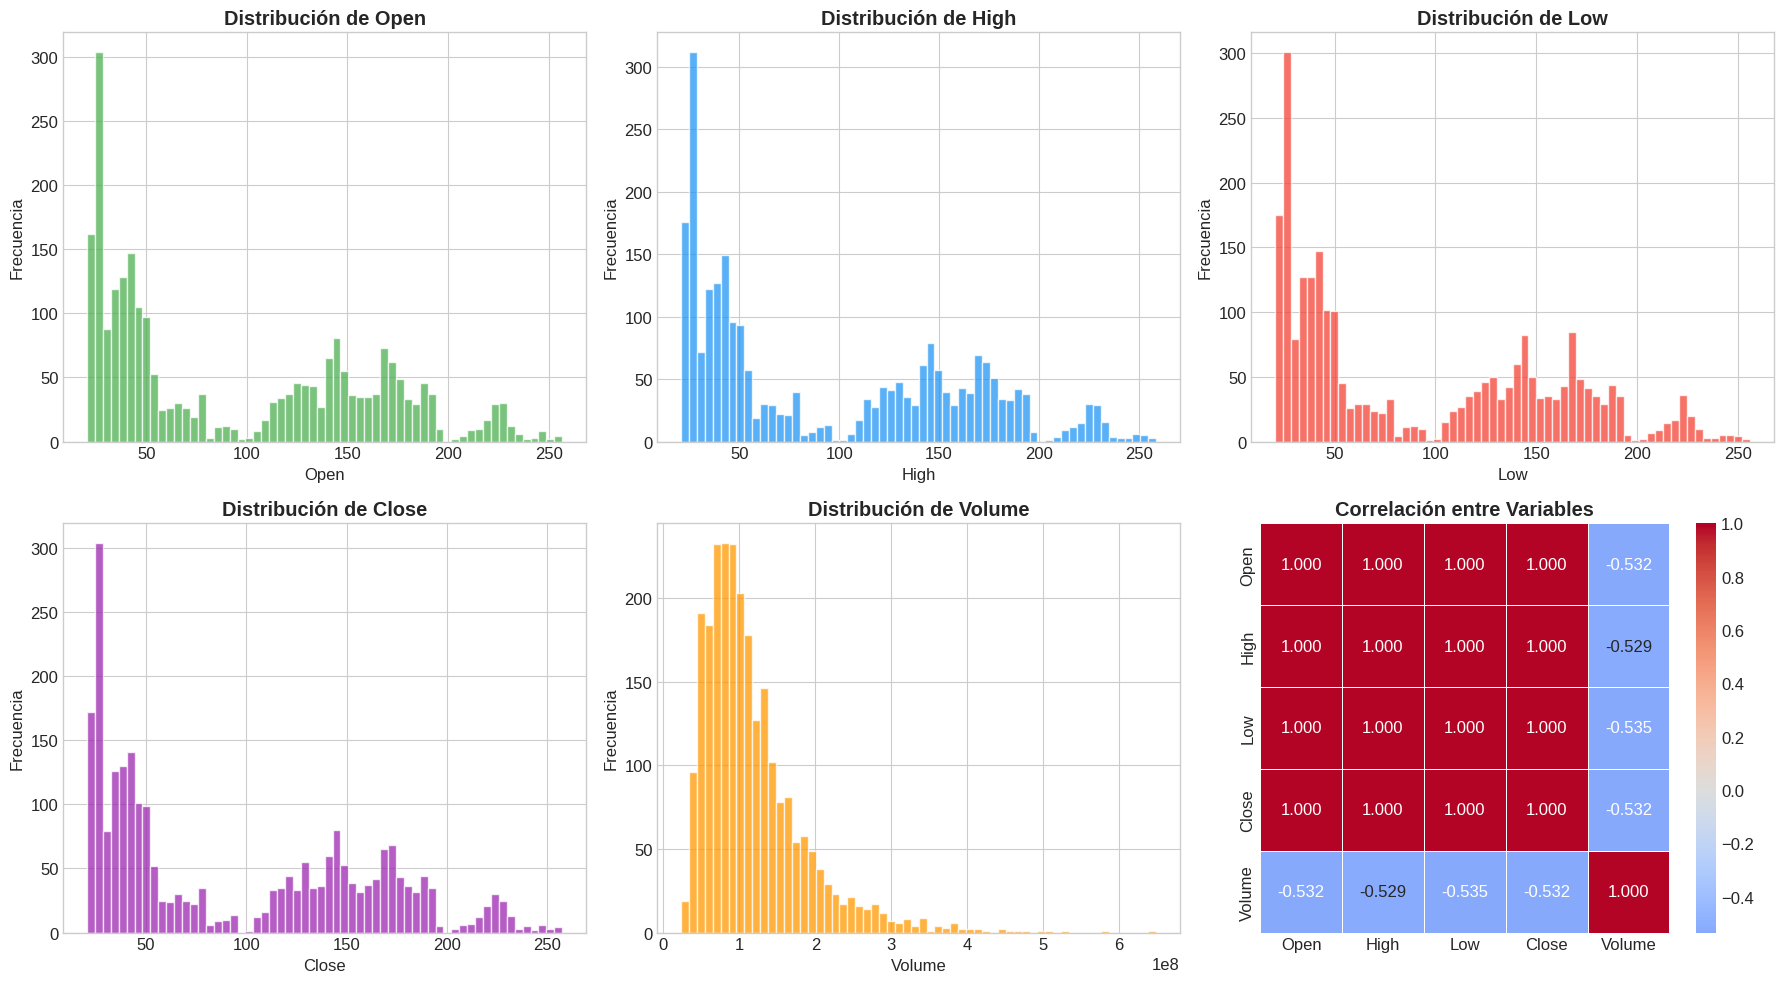

In [ ]:
# ── EDA 2: Distribución de variables y correlación ───────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

cols = ['Open', 'High', 'Low', 'Close', 'Volume']
colors = ['#4CAF50', '#2196F3', '#F44336', '#9C27B0', '#FF9800']

for i, (col, color) in enumerate(zip(cols, colors)):
    row, c = divmod(i, 3)
    axes[row, c].hist(df[col], bins=60, color=color, alpha=0.75, edgecolor='white')
    axes[row, c].set_title(f'Distribución de {col}', fontweight='bold')
    axes[row, c].set_xlabel(col)
    axes[row, c].set_ylabel('Frecuencia')

# Heatmap de correlaciones
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            ax=axes[1, 2], square=True, linewidths=0.5)
axes[1, 2].set_title('Correlación entre Variables', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

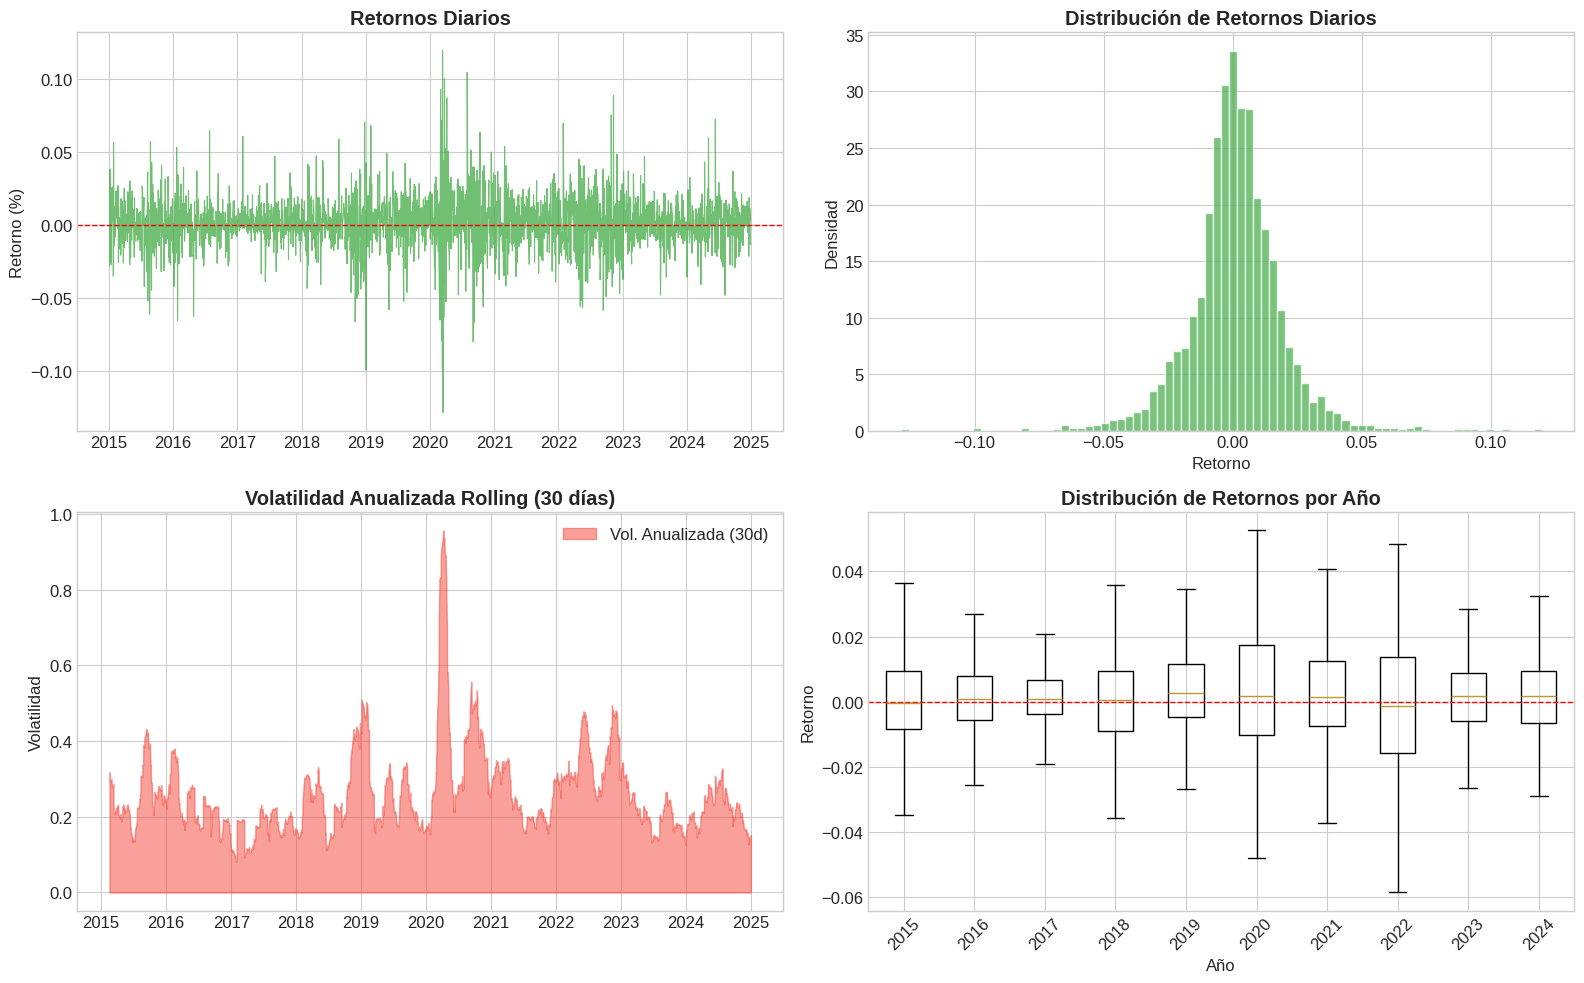

In [ ]:
# ── EDA 3: Retornos diarios y volatilidad ─────────────────────────────────────
df['Returns']    = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Volatility'] = df['Returns'].rolling(window=30).std() * np.sqrt(252)  # Vol anualizada

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Retornos diarios
axes[0, 0].plot(df.index, df['Returns'], color='#4CAF50', linewidth=0.8, alpha=0.8)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Retornos Diarios', fontweight='bold')
axes[0, 0].set_ylabel('Retorno (%)')

# Histograma de retornos
axes[0, 1].hist(df['Returns'].dropna(), bins=80, color='#4CAF50', alpha=0.75, edgecolor='white', density=True)
axes[0, 1].set_title('Distribución de Retornos Diarios', fontweight='bold')
axes[0, 1].set_xlabel('Retorno')
axes[0, 1].set_ylabel('Densidad')

# Volatilidad anualizada rolling 30d
axes[1, 0].fill_between(df.index, df['Volatility'], color='#F44336', alpha=0.5, label='Vol. Anualizada (30d)')
axes[1, 0].set_title('Volatilidad Anualizada Rolling (30 días)', fontweight='bold')
axes[1, 0].set_ylabel('Volatilidad')
axes[1, 0].legend()

# Box-plot por año
df['Year'] = df.index.year
df_by_year = [df[df['Year'] == y]['Returns'].dropna() for y in sorted(df['Year'].unique())]
axes[1, 1].boxplot(df_by_year, labels=sorted(df['Year'].unique()), showfliers=False)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Distribución de Retornos por Año', fontweight='bold')
axes[1, 1].set_xlabel('Año')
axes[1, 1].set_ylabel('Retorno')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('eda_returns.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ── EDA 4: Estadísticas de retornos ──────────────────────────────────────────
from scipy import stats

returns_clean = df['Returns'].dropna()
print('ESTADÍSTICAS DE RETORNOS DIARIOS')
print('=' * 45)
print(f'Media          : {returns_clean.mean():.4f} ({returns_clean.mean()*100:.2f}%)')
print(f'Std Dev        : {returns_clean.std():.4f}')
print(f'Skewness       : {returns_clean.skew():.4f}')
print(f'Kurtosis       : {returns_clean.kurtosis():.4f}')
print(f'Min            : {returns_clean.min():.4f}')
print(f'Max            : {returns_clean.max():.4f}')
print(f'VaR 95%        : {returns_clean.quantile(0.05):.4f}')
print(f'VaR 99%        : {returns_clean.quantile(0.01):.4f}')

# Test de normalidad Jarque-Bera
jb_stat, jb_pvalue = stats.jarque_bera(returns_clean)
print(f'\nTest Jarque-Bera:')
print(f'  Estadístico : {jb_stat:.2f}')
print(f'  p-valor     : {jb_pvalue:.6f}')
print(f'  Distribución: {"NO normal" if jb_pvalue < 0.05 else "Normal"} (α=0.05)')

ESTADÍSTICAS DE RETORNOS DIARIOS
Media          : 0.0011 (0.11%)
Std Dev        : 0.0179
Skewness       : -0.0036
Kurtosis       : 5.3113
Min            : -0.1286
Max            : 0.1198
VaR 95%        : -0.0270
VaR 99%        : -0.0480

Test Jarque-Bera:
  Estadístico : 2940.63
  p-valor     : 0.000000
  Distribución: NO normal (α=0.05)


---
## 5. Preprocesamiento de Datos

In [ ]:
# ── 5.1 Tratamiento de valores faltantes ─────────────────────────────────────
print('ANÁLISIS DE VALORES FALTANTES')
print('=' * 40)
missing = df[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Faltantes': missing, 'Porcentaje': missing_pct})
print(missing_df)

# Los datos de yfinance generalmente no tienen NaN en OHLCV
# pero eliminamos las filas con NaN de los indicadores derivados
df_clean = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
print(f'\nShape antes de limpiar : {df.shape}')
df_clean = df_clean.dropna()
print(f'Shape después de limpiar: {df_clean.shape}')

ANÁLISIS DE VALORES FALTANTES
        Faltantes  Porcentaje
Open            0         0.0
High            0         0.0
Low             0         0.0
Close           0         0.0
Volume          0         0.0

Shape antes de limpiar : (2515, 9)
Shape después de limpiar: (2515, 5)


Límite inferior (3×IQR): -0.0597
Límite superior (3×IQR): 0.0626
Outliers detectados    : 26

Top outliers por retorno:
                 Close   Returns
Date                            
2020-03-13   67.164764  0.119809
2020-07-31  102.978691  0.104689
2020-03-24   59.652607  0.100326
2020-03-02   72.200249  0.093101
2022-11-10  144.551956  0.088974


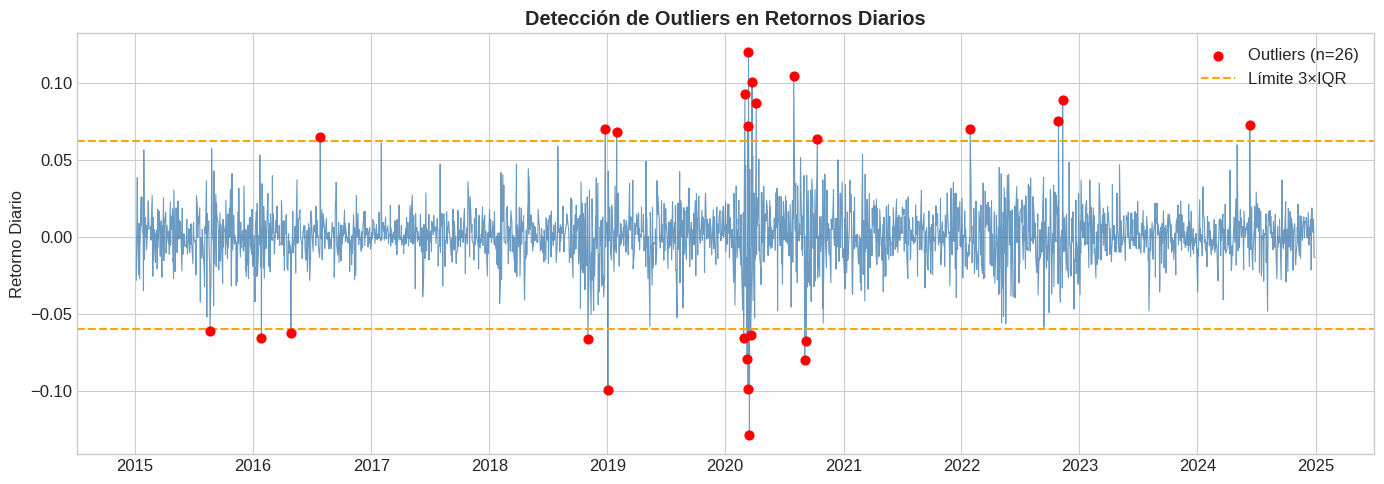

In [ ]:
# ── 5.2 Detección de outliers (método IQR en retornos) ───────────────────────
df_clean['Returns'] = df_clean['Close'].pct_change()

Q1 = df_clean['Returns'].quantile(0.25)
Q3 = df_clean['Returns'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 3 * IQR
upper = Q3 + 3 * IQR

outliers = df_clean[(df_clean['Returns'] < lower) | (df_clean['Returns'] > upper)]

print(f'Límite inferior (3×IQR): {lower:.4f}')
print(f'Límite superior (3×IQR): {upper:.4f}')
print(f'Outliers detectados    : {len(outliers)}')
print()
if len(outliers) > 0:
    print('Top outliers por retorno:')
    print(outliers.nlargest(5, 'Returns')[['Close', 'Returns']])

# Visualización de outliers
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_clean.index, df_clean['Returns'], color='steelblue', linewidth=0.8, alpha=0.8)
ax.scatter(outliers.index, outliers['Returns'], color='red', s=40, zorder=5, label=f'Outliers (n={len(outliers)})')
ax.axhline(lower, color='orange', linestyle='--', linewidth=1.5, label='Límite 3×IQR')
ax.axhline(upper, color='orange', linestyle='--', linewidth=1.5)
ax.set_title('Detección de Outliers en Retornos Diarios', fontweight='bold')
ax.set_ylabel('Retorno Diario')
ax.legend()
plt.tight_layout()
plt.savefig('outliers.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ── 5.3 Ingeniería de features (indicadores técnicos) ────────────────────────
df_feat = df_clean[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Medias móviles
df_feat['SMA_7']  = df_feat['Close'].rolling(7).mean()
df_feat['SMA_20'] = df_feat['Close'].rolling(20).mean()
df_feat['SMA_50'] = df_feat['Close'].rolling(50).mean()
df_feat['EMA_12'] = df_feat['Close'].ewm(span=12, adjust=False).mean()
df_feat['EMA_26'] = df_feat['Close'].ewm(span=26, adjust=False).mean()

# MACD
df_feat['MACD']        = df_feat['EMA_12'] - df_feat['EMA_26']
df_feat['MACD_Signal'] = df_feat['MACD'].ewm(span=9, adjust=False).mean()
df_feat['MACD_Hist']   = df_feat['MACD'] - df_feat['MACD_Signal']

# RSI (Relative Strength Index)
delta = df_feat['Close'].diff()
gain  = delta.clip(lower=0).rolling(14).mean()
loss  = (-delta.clip(upper=0)).rolling(14).mean()
rs    = gain / loss
df_feat['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df_feat['BB_mid']   = df_feat['Close'].rolling(20).mean()
bb_std              = df_feat['Close'].rolling(20).std()
df_feat['BB_upper'] = df_feat['BB_mid'] + 2 * bb_std
df_feat['BB_lower'] = df_feat['BB_mid'] - 2 * bb_std
df_feat['BB_width'] = (df_feat['BB_upper'] - df_feat['BB_lower']) / df_feat['BB_mid']

# Retornos y volatilidad
df_feat['Return_1d']  = df_feat['Close'].pct_change(1)
df_feat['Return_5d']  = df_feat['Close'].pct_change(5)
df_feat['Volatility'] = df_feat['Return_1d'].rolling(20).std()

# Volume features
df_feat['Volume_MA20'] = df_feat['Volume'].rolling(20).mean()
df_feat['Volume_Ratio'] = df_feat['Volume'] / df_feat['Volume_MA20']

# Precio relativo
df_feat['High_Low_Ratio'] = (df_feat['High'] - df_feat['Low']) / df_feat['Close']
df_feat['Open_Close_Ratio'] = (df_feat['Close'] - df_feat['Open']) / df_feat['Open']

# Eliminar NaN generados por rolling windows
df_feat = df_feat.dropna()

print(f'Dataset con features: {df_feat.shape}')
print(f'Features creadas    : {df_feat.shape[1]}')
print(f'\nLista de features:')
for i, col in enumerate(df_feat.columns):
    print(f'  {i+1:02d}. {col}')

df_feat.tail()

Dataset con features: (2466, 25)
Features creadas    : 25

Lista de features:
  01. Open
  02. High
  03. Low
  04. Close
  05. Volume
  06. SMA_7
  07. SMA_20
  08. SMA_50
  09. EMA_12
  10. EMA_26
  11. MACD
  12. MACD_Signal
  13. MACD_Hist
  14. RSI
  15. BB_mid
  16. BB_upper
  17. BB_lower
  18. BB_width
  19. Return_1d
  20. Return_5d
  21. Volatility
  22. Volume_MA20
  23. Volume_Ratio
  24. High_Low_Ratio
  25. Open_Close_Ratio


,Open,High,Low,Close,Volume,SMA_7,SMA_20,SMA_50,EMA_12,EMA_26,...,BB_upper,BB_lower,BB_width,Return_1d,Return_5d,Volatility,Volume_MA20,Volume_Ratio,High_Low_Ratio,Open_Close_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-23,253.385849,254.261058,252.073014,253.883133,40858800,250.098079,243.695765,234.001651,247.699230,241.958778,...,256.772111,230.619419,0.107317,0.003065,0.016850,0.008893,50408480.0,0.810554,0.008618,0.001963
2024-12-24,254.101958,256.807166,253.903032,256.797241,23234700,251.528841,244.955386,234.541785,249.098924,243.057923,...,257.981118,231.929655,0.106352,0.011478,0.018621,0.008828,47062575.0,0.493698,0.011309,0.010607
2024-12-26,256.787255,258.686881,256.230300,257.612732,27237100,252.662646,246.146877,235.047562,250.408741,244.136057,...,259.228984,233.064770,0.106295,0.003176,0.044225,0.008782,46125120.0,0.590505,0.009536,0.003215
2024-12-27,256.429191,257.294489,251.685117,254.201370,42355300,252.962437,247.174265,235.526242,250.992222,244.881636,...,259.319048,235.029482,0.098269,-0.013242,0.023220,0.009615,46567965.0,0.909537,0.022067,-0.008688
2024-12-30,250.859624,252.122728,249.387669,250.829788,35557500,253.552072,247.913725,235.930138,250.967232,245.322240,...,258.955015,236.872435,0.089074,-0.013263,-0.008998,0.010262,46921770.0,0.757804,0.010904,-0.000119


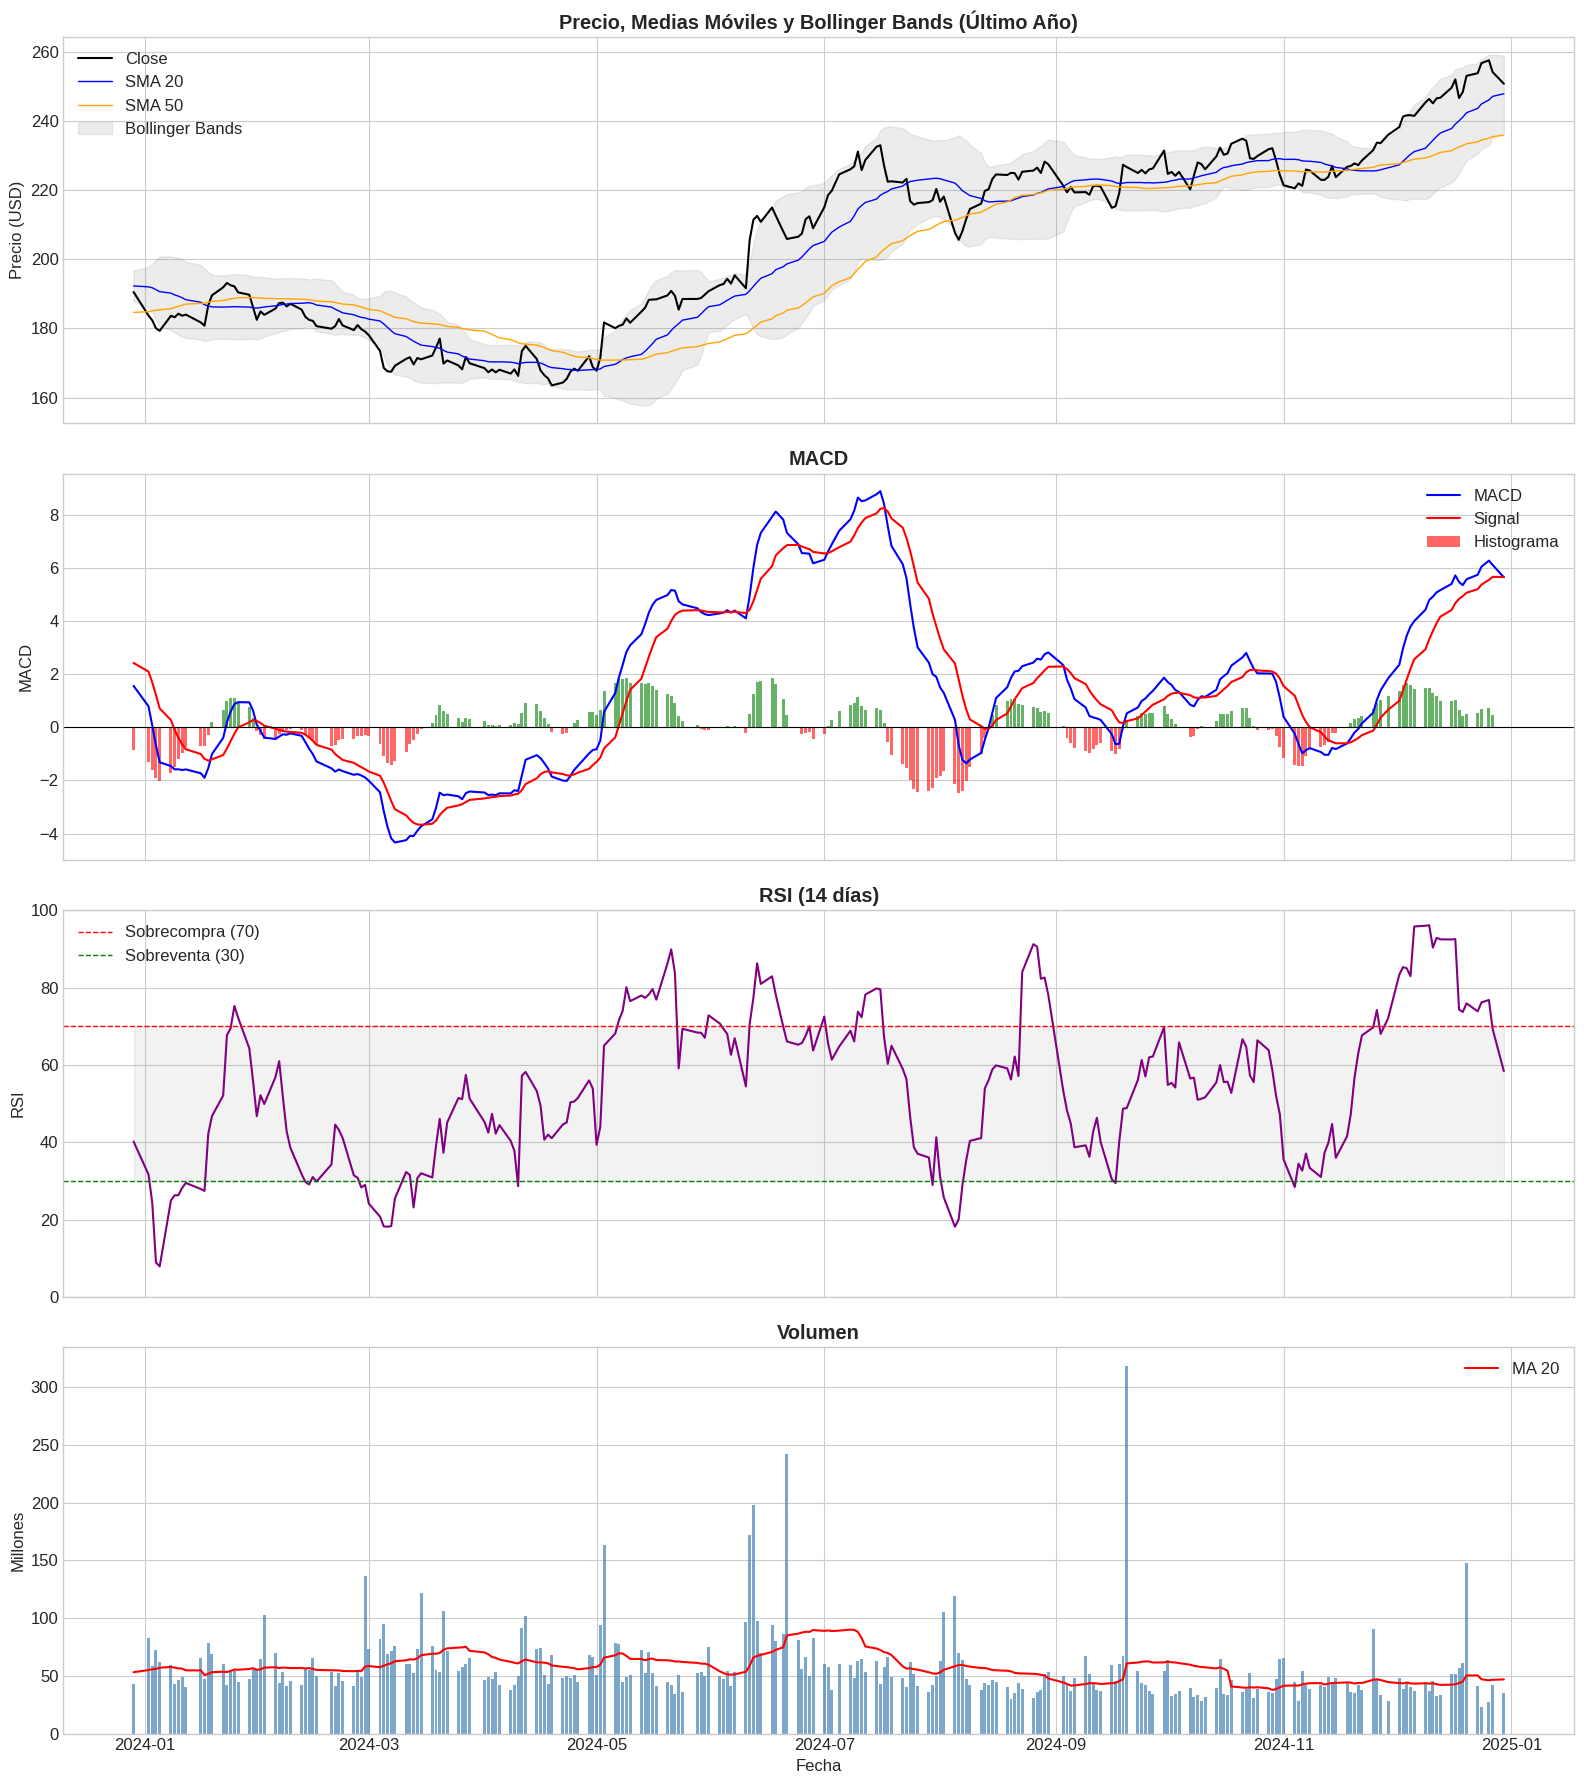

In [ ]:
# ── 5.4 Visualización de indicadores técnicos ─────────────────────────────────
df_vis = df_feat.iloc[-252:]  # Último año

fig, axes = plt.subplots(4, 1, figsize=(16, 18), sharex=True)

# Precio + Medias móviles + Bollinger
axes[0].plot(df_vis.index, df_vis['Close'], label='Close', color='black', linewidth=1.5)
axes[0].plot(df_vis.index, df_vis['SMA_20'], label='SMA 20', color='blue', linewidth=1)
axes[0].plot(df_vis.index, df_vis['SMA_50'], label='SMA 50', color='orange', linewidth=1)
axes[0].fill_between(df_vis.index, df_vis['BB_upper'], df_vis['BB_lower'], alpha=0.15, color='gray', label='Bollinger Bands')
axes[0].set_title('Precio, Medias Móviles y Bollinger Bands (Último Año)', fontweight='bold')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend(loc='upper left')

# MACD
axes[1].plot(df_vis.index, df_vis['MACD'], label='MACD', color='blue')
axes[1].plot(df_vis.index, df_vis['MACD_Signal'], label='Signal', color='red')
axes[1].bar(df_vis.index, df_vis['MACD_Hist'], label='Histograma', color=['green' if x > 0 else 'red' for x in df_vis['MACD_Hist']], alpha=0.6)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_title('MACD', fontweight='bold')
axes[1].set_ylabel('MACD')
axes[1].legend()

# RSI
axes[2].plot(df_vis.index, df_vis['RSI'], color='purple', linewidth=1.5)
axes[2].axhline(70, color='red', linestyle='--', linewidth=1, label='Sobrecompra (70)')
axes[2].axhline(30, color='green', linestyle='--', linewidth=1, label='Sobreventa (30)')
axes[2].fill_between(df_vis.index, 30, 70, alpha=0.1, color='gray')
axes[2].set_ylim(0, 100)
axes[2].set_title('RSI (14 días)', fontweight='bold')
axes[2].set_ylabel('RSI')
axes[2].legend()

# Volumen
axes[3].bar(df_vis.index, df_vis['Volume'] / 1e6, color='steelblue', alpha=0.7)
axes[3].plot(df_vis.index, df_vis['Volume_MA20'] / 1e6, color='red', linewidth=1.5, label='MA 20')
axes[3].set_title('Volumen', fontweight='bold')
axes[3].set_ylabel('Millones')
axes[3].set_xlabel('Fecha')
axes[3].legend()

plt.tight_layout()
plt.savefig('technical_indicators.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ── 5.5 Normalización y split train/val/test ──────────────────────────────────

# Features seleccionadas para el modelo
FEATURE_COLS = ['Open', 'High', 'Low', 'Close', 'Volume',
                'SMA_7', 'SMA_20', 'EMA_12', 'MACD', 'MACD_Signal',
                'RSI', 'BB_width', 'Return_1d', 'Return_5d',
                'Volatility', 'Volume_Ratio', 'High_Low_Ratio']
TARGET_COL   = 'Close'
SEQ_LEN      = 60  # Ventana de 60 días

data = df_feat[FEATURE_COLS].values

# Splits cronológicos (sin shuffle para series de tiempo)
n = len(data)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_data = data[:train_end]
val_data   = data[train_end:val_end]
test_data  = data[val_end:]

print(f'Total muestras : {n}')
print(f'Train          : {len(train_data)} ({len(train_data)/n*100:.1f}%)')
print(f'Validation     : {len(val_data)} ({len(val_data)/n*100:.1f}%)')
print(f'Test           : {len(test_data)} ({len(test_data)/n*100:.1f}%)')

# Escalado: fit SOLO en train → transform en val y test
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled   = scaler.transform(val_data)
test_scaled  = scaler.transform(test_data)

# Scaler separado para el precio de cierre (para inversión de predicciones)
close_idx    = FEATURE_COLS.index(TARGET_COL)
scaler_close = MinMaxScaler(feature_range=(0, 1))
_ = scaler_close.fit_transform(train_data[:, close_idx].reshape(-1, 1))

print(f'\n✅ Normalización completada (MinMaxScaler [0,1])')
print(f'   Índice de Close en features: {close_idx}')

Total muestras : 2466
Train          : 1726 (70.0%)
Validation     : 370 (15.0%)
Test           : 370 (15.0%)

✅ Normalización completada (MinMaxScaler [0,1])
   Índice de Close en features: 3


In [ ]:
# ── 5.6 Creación de secuencias temporales ────────────────────────────────────

def create_sequences(data, seq_len, target_idx):
    """Crea secuencias X de longitud seq_len y targets Y (siguiente día)."""
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])    # (seq_len, n_features)
        y.append(data[i, target_idx])     # precio cierre día siguiente
    return np.array(X), np.array(y)


X_train, y_train = create_sequences(train_scaled, SEQ_LEN, close_idx)
X_val,   y_val   = create_sequences(val_scaled,   SEQ_LEN, close_idx)
X_test,  y_test  = create_sequences(test_scaled,  SEQ_LEN, close_idx)

print('Shapes de los conjuntos:')
print(f'  X_train: {X_train.shape}  y_train: {y_train.shape}')
print(f'  X_val  : {X_val.shape}  y_val  : {y_val.shape}')
print(f'  X_test : {X_test.shape}  y_test : {y_test.shape}')

# Conversión a tensores PyTorch
def to_tensors(X, y):
    return (torch.FloatTensor(X).to(device),
            torch.FloatTensor(y).unsqueeze(1).to(device))

X_tr, y_tr = to_tensors(X_train, y_train)
X_vl, y_vl = to_tensors(X_val,   y_val)
X_te, y_te = to_tensors(X_test,  y_test)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_vl, y_vl), batch_size=BATCH_SIZE, shuffle=False)

print(f'\nBatch size    : {BATCH_SIZE}')
print(f'Batches/epoch : {len(train_loader)}')

Shapes de los conjuntos:
  X_train: (1666, 60, 17)  y_train: (1666,)
  X_val  : (310, 60, 17)  y_val  : (310,)
  X_test : (310, 60, 17)  y_test : (310,)

Batch size    : 32
Batches/epoch : 53


---
## 6. 🧠 Arquitecturas de los Modelos

### 6.1 Modelo 1: LSTM (Long Short-Term Memory)

**Justificación:** Las LSTM son un tipo especial de RNN diseñadas para aprender dependencias temporales a largo plazo mediante puertas de entrada, olvido y salida, lo que las hace ideales para series de tiempo financieras.

**Arquitectura:**
```
Input (batch, 60, 17)
  → LSTM Layer 1 (hidden=128, dropout=0.2)
  → LSTM Layer 2 (hidden=64,  dropout=0.2)
  → LSTM Layer 3 (hidden=32)
  → FC Layer 1   (32 → 64, ReLU)
  → Dropout (0.3)
  → FC Layer 2   (64 → 1)
  Output (batch, 1)  ← precio normalizado
```

### 6.2 Modelo 2: Transformer Temporal

**Justificación:** Los Transformers usan mecanismos de auto-atención multi-cabeza que capturan dependencias de largo alcance sin el problema del gradiente evanescente. Arquitectura estado del arte para secuencias temporales.

**Arquitectura:**
```
Input (batch, 60, 17)
  → Linear Projection (17 → d_model=64)
  → Positional Encoding (sinusoidal)
  → Transformer Encoder ×3 (nhead=4, dim_ff=256)
  → Global Average Pooling
  → FC Layer 1 (64 → 32, ReLU)
  → Dropout (0.2)
  → FC Layer 2 (32 → 1)
  Output (batch, 1)
```

In [ ]:
# ── 6.1 Implementación LSTM ───────────────────────────────────────────────────

class LSTMPredictor(nn.Module):
    """LSTM apilado de 3 capas para predicción de series de tiempo."""

    def __init__(self, input_size, hidden_sizes=[128, 64, 32],
                 fc_hidden=64, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_sizes = hidden_sizes

        # Capas LSTM apiladas
        self.lstm1 = nn.LSTM(input_size,      hidden_sizes[0],
                             batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1],
                             batch_first=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_sizes[1], hidden_sizes[2],
                             batch_first=True)

        # Capas fully-connected
        self.fc1     = nn.Linear(hidden_sizes[2], fc_hidden)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(dropout + 0.1)
        self.fc2     = nn.Linear(fc_hidden, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.lstm1(x)          # (batch, seq_len, 128)
        out, _ = self.lstm2(out)         # (batch, seq_len, 64)
        out, _ = self.lstm3(out)         # (batch, seq_len, 32)

        out = out[:, -1, :]             # Último paso temporal → (batch, 32)
        out = self.relu(self.fc1(out))   # (batch, 64)
        out = self.dropout(out)
        out = self.fc2(out)             # (batch, 1)
        return out


INPUT_SIZE = X_train.shape[2]  # número de features

lstm_model = LSTMPredictor(input_size=INPUT_SIZE).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable    = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

print('ARQUITECTURA LSTM')
print('=' * 55)
print(lstm_model)
print('=' * 55)
print(f'Total parámetros     : {total_params:,}')
print(f'Parámetros entrenables: {trainable:,}')
print(f'Dispositivo          : {next(lstm_model.parameters()).device}')

ARQUITECTURA LSTM
LSTMPredictor(
  (lstm1): LSTM(17, 128, batch_first=True, dropout=0.2)
  (lstm2): LSTM(128, 64, batch_first=True, dropout=0.2)
  (lstm3): LSTM(64, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.30000000000000004, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
Total parámetros     : 139,649
Parámetros entrenables: 139,649
Dispositivo          : cuda:0


In [ ]:
# ── 6.2 Implementación Transformer Temporal ───────────────────────────────────

class PositionalEncoding(nn.Module):
    """Codificación posicional sinusoidal para el Transformer."""

    def __init__(self, d_model, max_len=500, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float()
                        * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)             # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerPredictor(nn.Module):
    """Encoder Transformer para predicción temporal."""

    def __init__(self, input_size, d_model=64, nhead=4,
                 num_layers=3, dim_feedforward=256,
                 dropout=0.2, fc_hidden=32):
        super().__init__()

        # Proyección de entrada al espacio d_model
        self.input_proj = nn.Linear(input_size, d_model)

        # Codificación posicional
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # Encoder Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True,
            norm_first=True  # Pre-LN para mayor estabilidad
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Cabeza de predicción
        self.fc1     = nn.Linear(d_model, fc_hidden)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2     = nn.Linear(fc_hidden, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.input_proj(x)           # (batch, seq_len, d_model)
        x = self.pos_encoder(x)          # añade info posicional
        x = self.transformer(x)          # (batch, seq_len, d_model)
        x = x.mean(dim=1)               # Global Average Pooling → (batch, d_model)
        x = self.relu(self.fc1(x))       # (batch, fc_hidden)
        x = self.dropout(x)
        x = self.fc2(x)                 # (batch, 1)
        return x


transformer_model = TransformerPredictor(input_size=INPUT_SIZE).to(device)

total_params = sum(p.numel() for p in transformer_model.parameters())
trainable    = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

print('ARQUITECTURA TRANSFORMER')
print('=' * 55)
print(transformer_model)
print('=' * 55)
print(f'Total parámetros     : {total_params:,}')
print(f'Parámetros entrenables: {trainable:,}')
print(f'Dispositivo          : {next(transformer_model.parameters()).device}')

ARQUITECTURA TRANSFORMER
TransformerPredictor(
  (input_proj): Linear(in_features=17, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout

---
## 7. 🏋️ Entrenamiento de los Modelos

In [ ]:
# ── Función de entrenamiento genérica ─────────────────────────────────────────

def train_model(model, train_loader, X_val, y_val,
                n_epochs=100, lr=0.001, patience=15, model_name='model'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)  # ← sin verbose

    best_val_loss = float('inf')
    best_state    = None
    patience_cnt  = 0
    history       = {'train_loss': [], 'val_loss': []}

    print(f'\n🚀 Entrenando {model_name}...')
    print(f'   Épocas máx: {n_epochs}  |  LR inicial: {lr}  |  Paciencia: {patience}')
    print('-' * 60)

    for epoch in range(1, n_epochs + 1):
        # — TRAIN —
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss  = criterion(preds, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # — VALIDATION —
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss  = criterion(val_preds, y_val).item()

        scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state    = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_cnt  = 0
        else:
            patience_cnt += 1

        if epoch % 10 == 0 or epoch == 1:
            current_lr = optimizer.param_groups[0]['lr']  # ← mostramos LR actual manualmente
            print(f'  Época {epoch:>3}/{n_epochs}  '
                  f'Train Loss: {train_loss:.6f}  '
                  f'Val Loss: {val_loss:.6f}  '
                  f'LR: {current_lr:.6f}  '
                  f'(mejor: {best_val_loss:.6f})')

        if patience_cnt >= patience:
            print(f'\n⏹ Early stopping en época {epoch}. Mejor Val Loss: {best_val_loss:.6f}')
            break

    model.load_state_dict(best_state)
    print(f'\n✅ {model_name} entrenado. Mejor Val Loss: {best_val_loss:.6f}')
    return history

In [ ]:
# ── Entrenamiento LSTM ────────────────────────────────────────────────────────
history_lstm = train_model(
    model       = lstm_model,
    train_loader= train_loader,
    X_val       = X_vl,
    y_val       = y_vl,
    n_epochs    = 100,
    lr          = 0.001,
    patience    = 15,
    model_name  = 'LSTM'
)


🚀 Entrenando LSTM...
   Épocas máx: 100  |  LR inicial: 0.001  |  Paciencia: 15
------------------------------------------------------------
  Época   1/100  Train Loss: 0.042307  Val Loss: 0.028415  LR: 0.001000  (mejor: 0.028415)
  Época  10/100  Train Loss: 0.002297  Val Loss: 0.001060  LR: 0.001000  (mejor: 0.001060)
  Época  20/100  Train Loss: 0.002227  Val Loss: 0.000922  LR: 0.000500  (mejor: 0.000922)
  Época  30/100  Train Loss: 0.001916  Val Loss: 0.006593  LR: 0.000500  (mejor: 0.000736)
  Época  40/100  Train Loss: 0.001622  Val Loss: 0.001938  LR: 0.000250  (mejor: 0.000706)
  Época  50/100  Train Loss: 0.001354  Val Loss: 0.000859  LR: 0.000250  (mejor: 0.000652)
  Época  60/100  Train Loss: 0.001612  Val Loss: 0.000652  LR: 0.000125  (mejor: 0.000652)
  Época  70/100  Train Loss: 0.001401  Val Loss: 0.000831  LR: 0.000125  (mejor: 0.000641)
  Época  80/100  Train Loss: 0.001326  Val Loss: 0.000617  LR: 0.000063  (mejor: 0.000617)
  Época  90/100  Train Loss: 0.001356  

In [ ]:
# ── Entrenamiento Transformer ─────────────────────────────────────────────────
history_transformer = train_model(
    model       = transformer_model,
    train_loader= train_loader,
    X_val       = X_vl,
    y_val       = y_vl,
    n_epochs    = 100,
    lr          = 0.0005,
    patience    = 15,
    model_name  = 'Transformer'
)


🚀 Entrenando Transformer...
   Épocas máx: 100  |  LR inicial: 0.0005  |  Paciencia: 15
------------------------------------------------------------
  Época   1/100  Train Loss: 0.017486  Val Loss: 0.023236  LR: 0.000500  (mejor: 0.023236)
  Época  10/100  Train Loss: 0.004111  Val Loss: 0.027801  LR: 0.000500  (mejor: 0.003962)
  Época  20/100  Train Loss: 0.003150  Val Loss: 0.001000  LR: 0.000250  (mejor: 0.001000)
  Época  30/100  Train Loss: 0.002568  Val Loss: 0.000912  LR: 0.000250  (mejor: 0.000738)
  Época  40/100  Train Loss: 0.002908  Val Loss: 0.001024  LR: 0.000250  (mejor: 0.000681)
  Época  50/100  Train Loss: 0.002580  Val Loss: 0.001035  LR: 0.000125  (mejor: 0.000681)

⏹ Early stopping en época 54. Mejor Val Loss: 0.000681

✅ Transformer entrenado. Mejor Val Loss: 0.000681


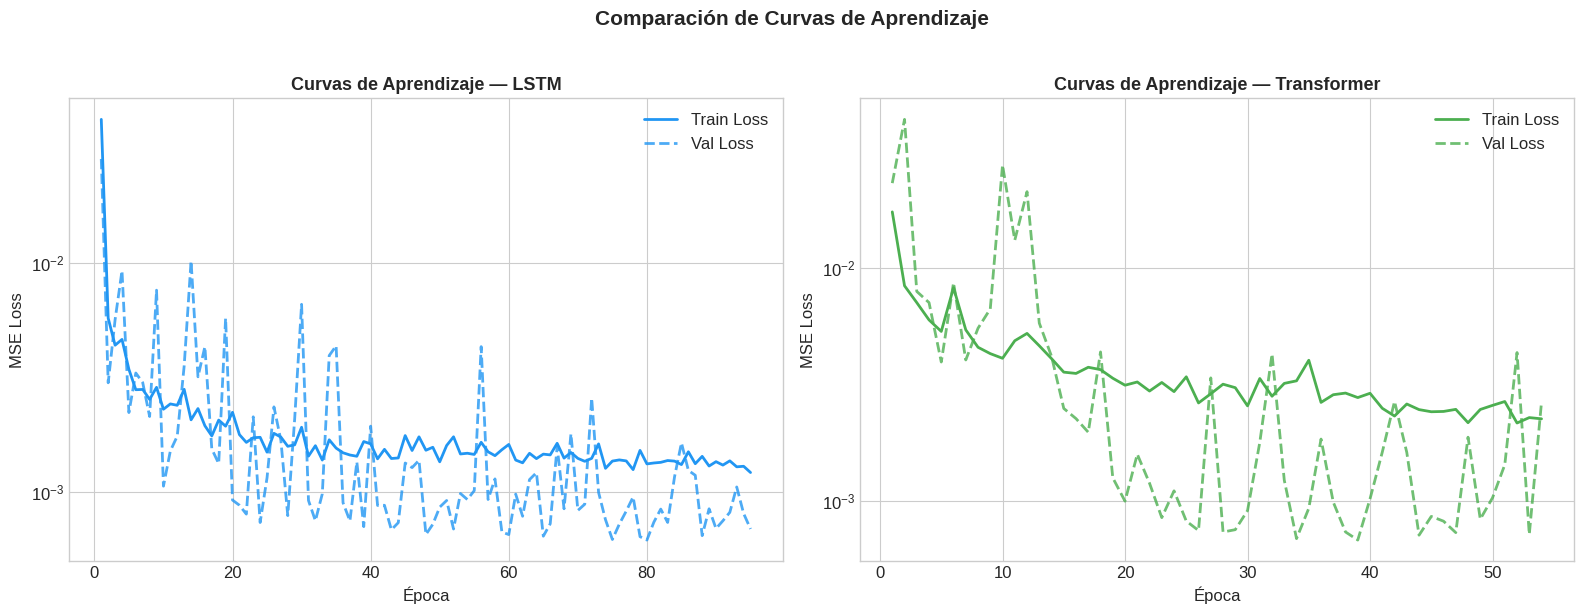

In [ ]:
# ── Curvas de aprendizaje ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, history, name, color in zip(
    axes,
    [history_lstm, history_transformer],
    ['LSTM', 'Transformer'],
    ['#2196F3', '#4CAF50']
):
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], color=color,       linewidth=2, label='Train Loss')
    ax.plot(epochs, history['val_loss'],   color=color, linestyle='--', linewidth=2, label='Val Loss', alpha=0.8)
    ax.set_title(f'Curvas de Aprendizaje — {name}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Época')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    ax.set_yscale('log')  # escala log para ver convergencia

plt.suptitle('Comparación de Curvas de Aprendizaje', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. 📊 Evaluación de los Modelos

In [ ]:
# ── Función de evaluación ─────────────────────────────────────────────────────

def evaluate_model(model, X_test, y_test_scaled, scaler_close, model_name):
    """Evalúa el modelo en el set de test y retorna métricas + predicciones."""
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test).cpu().numpy()

    y_test_np = y_test_scaled.cpu().numpy()

    # Inversión de escala → precios reales en USD
    y_pred_real = scaler_close.inverse_transform(y_pred_scaled)
    y_test_real = scaler_close.inverse_transform(y_test_np)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae  = mean_absolute_error(y_test_real, y_pred_real)
    r2   = r2_score(y_test_real, y_pred_real)
    mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100

    print(f'\n📈 MÉTRICAS DE EVALUACIÓN — {model_name}')
    print('=' * 45)
    print(f'  RMSE : ${rmse:.4f}')
    print(f'  MAE  : ${mae:.4f}')
    print(f'  R²   : {r2:.4f}')
    print(f'  MAPE : {mape:.4f}%')

    return {
        'model_name' : model_name,
        'y_test'     : y_test_real.flatten(),
        'y_pred'     : y_pred_real.flatten(),
        'rmse'       : rmse,
        'mae'        : mae,
        'r2'         : r2,
        'mape'       : mape
    }


results_lstm        = evaluate_model(lstm_model,        X_te, y_te, scaler_close, 'LSTM')
results_transformer = evaluate_model(transformer_model, X_te, y_te, scaler_close, 'Transformer')


📈 MÉTRICAS DE EVALUACIÓN — LSTM
  RMSE : $12.2756
  MAE  : $9.6609
  R²   : 0.7544
  MAPE : 4.4733%

📈 MÉTRICAS DE EVALUACIÓN — Transformer
  RMSE : $10.7168
  MAE  : $8.2609
  R²   : 0.8128
  MAPE : 3.8260%


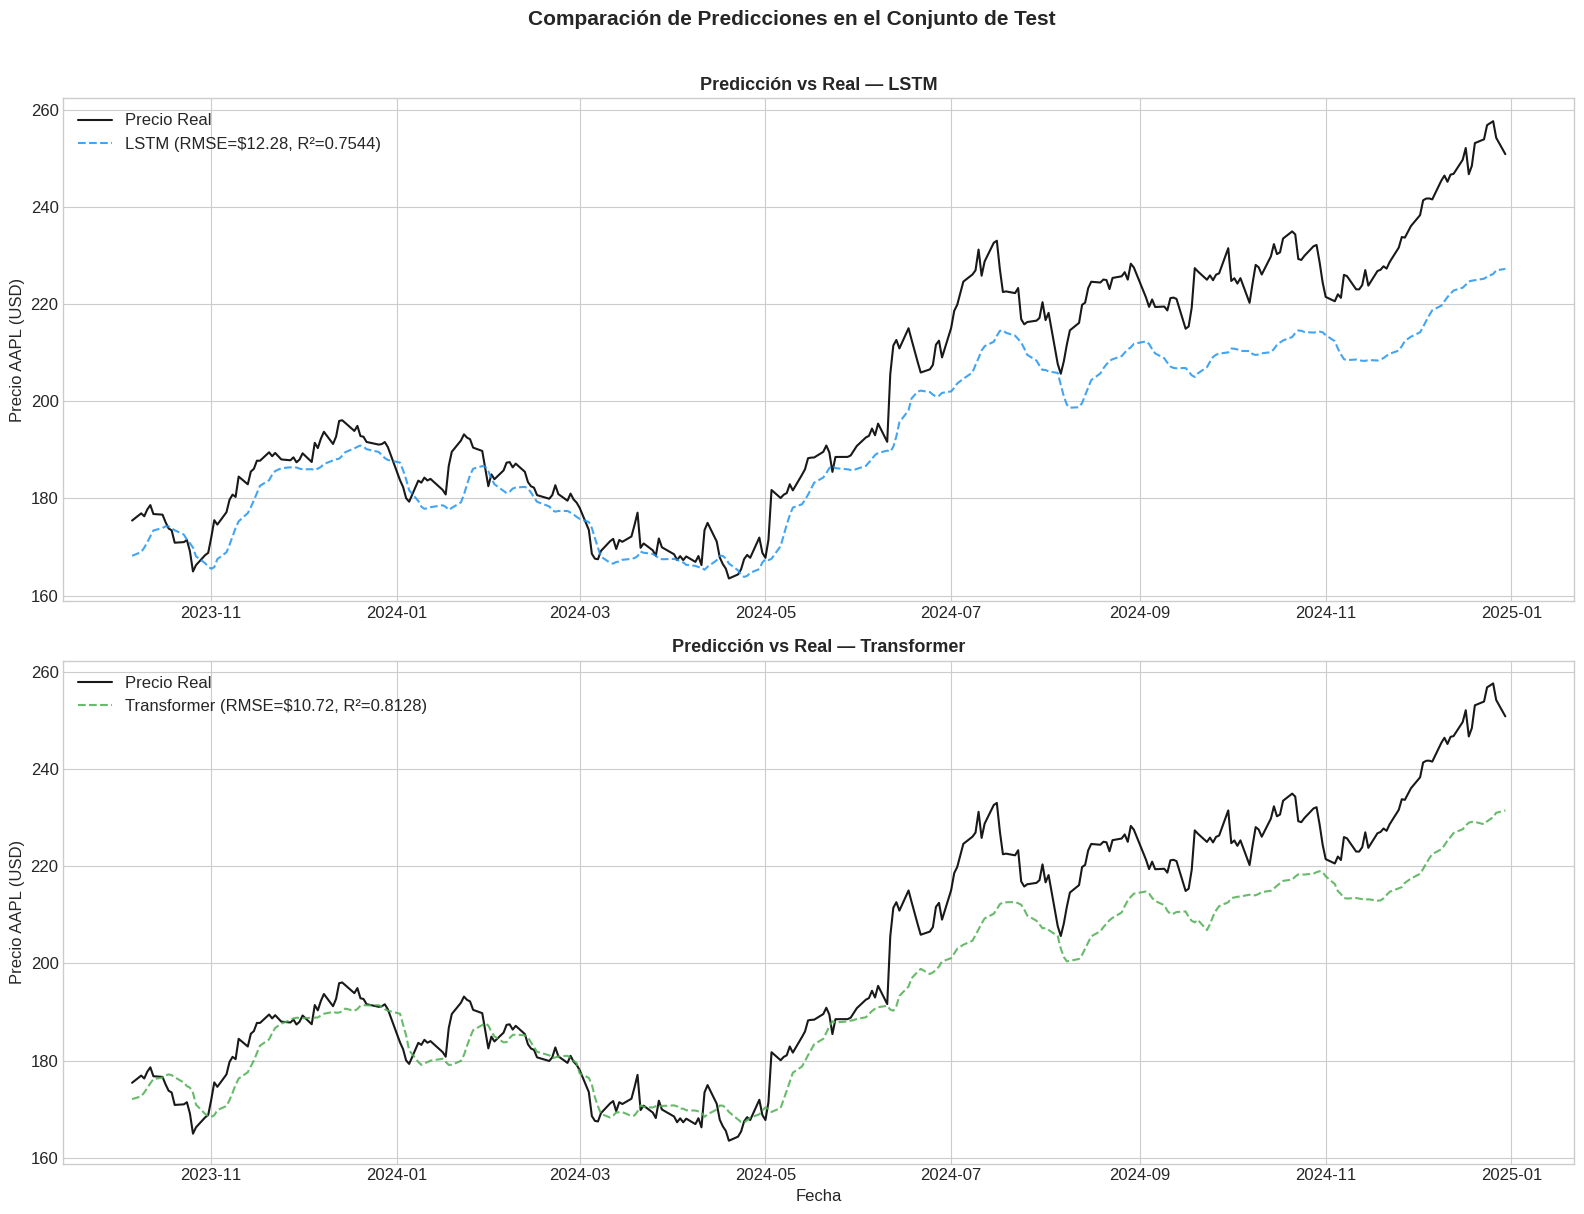

In [ ]:
# ── Predicciones vs Valores Reales ────────────────────────────────────────────
# Fechas del test set
test_dates = df_feat.index[val_end + SEQ_LEN:]

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for ax, results, color in zip(
    axes,
    [results_lstm, results_transformer],
    ['#2196F3', '#4CAF50']
):
    n_plot = min(len(test_dates), len(results['y_test']))
    ax.plot(test_dates[:n_plot], results['y_test'][:n_plot],
            color='black', linewidth=1.5, label='Precio Real', alpha=0.9)
    ax.plot(test_dates[:n_plot], results['y_pred'][:n_plot],
            color=color, linewidth=1.5, linestyle='--',
            label=f"{results['model_name']} (RMSE=${results['rmse']:.2f}, R²={results['r2']:.4f})",
            alpha=0.85)
    ax.set_title(f"Predicción vs Real — {results['model_name']}", fontweight='bold', fontsize=13)
    ax.set_ylabel('Precio AAPL (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axes[1].set_xlabel('Fecha')
plt.suptitle('Comparación de Predicciones en el Conjunto de Test', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('predictions_vs_real.png', dpi=150, bbox_inches='tight')
plt.show()

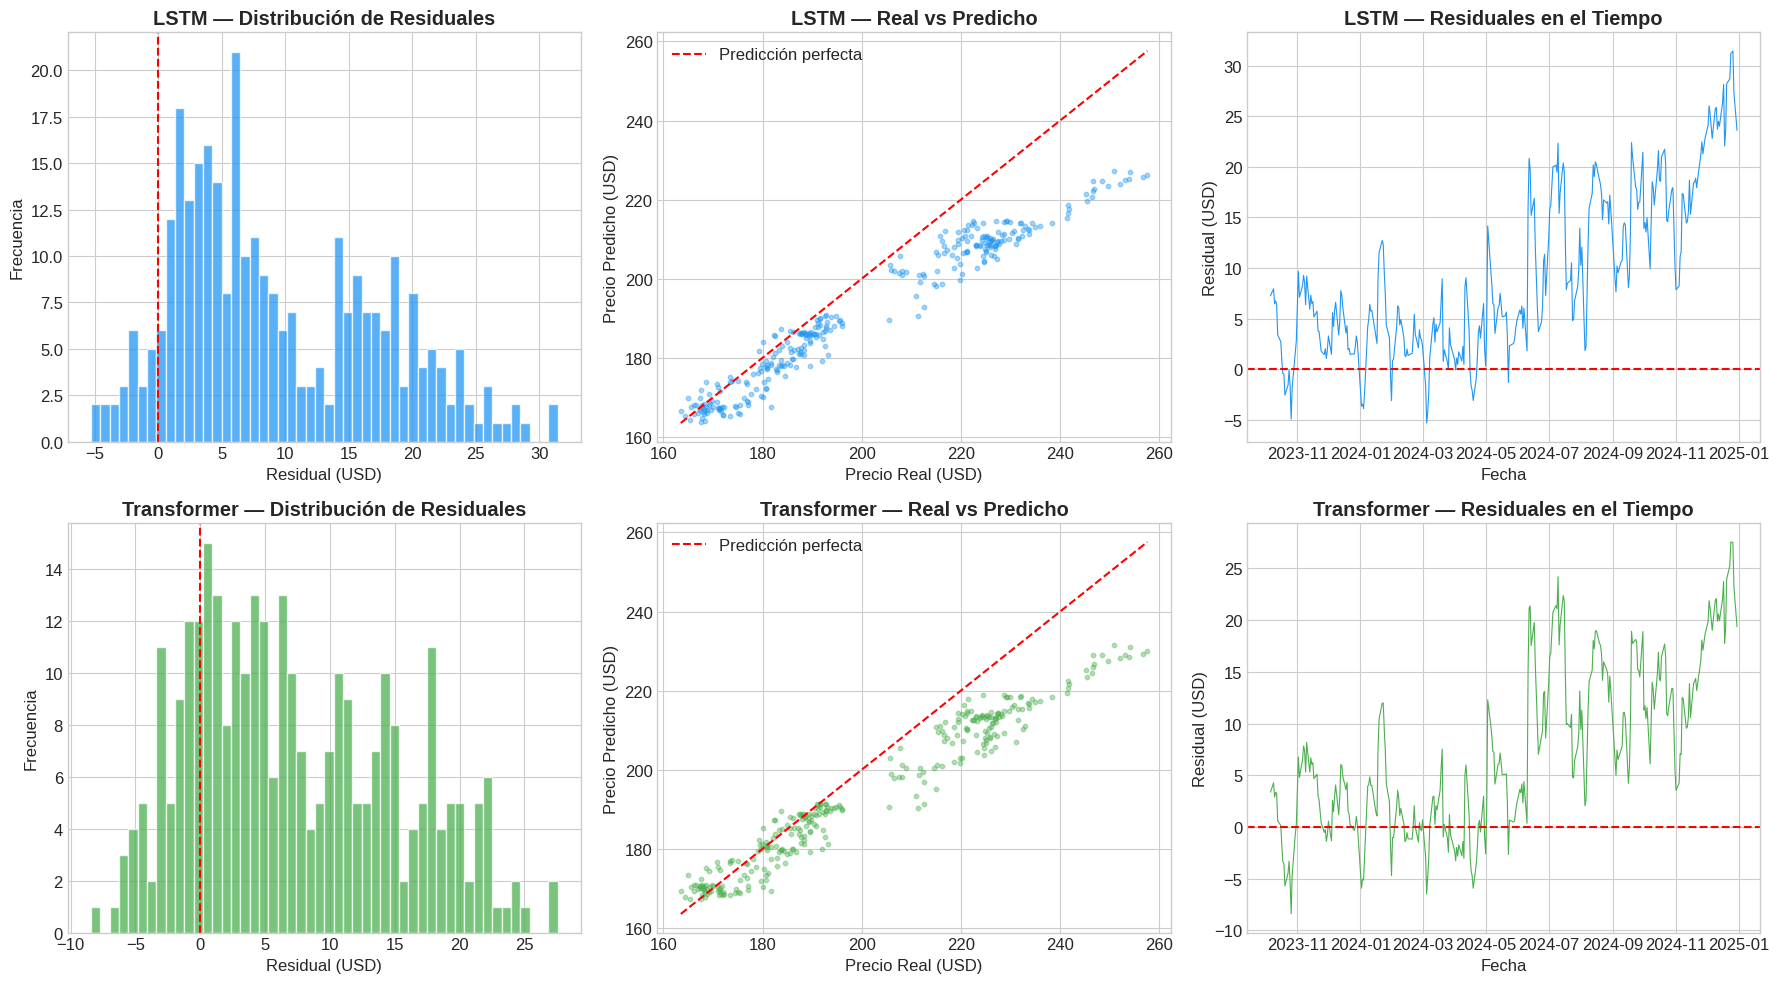

In [ ]:
# ── Análisis de residuales ────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row, (results, name, color) in enumerate(zip(
    [results_lstm, results_transformer],
    ['LSTM', 'Transformer'],
    ['#2196F3', '#4CAF50']
)):
    residuals = results['y_test'] - results['y_pred']

    # Histograma de residuales
    axes[row, 0].hist(residuals, bins=50, color=color, alpha=0.75, edgecolor='white')
    axes[row, 0].axvline(0, color='red', linestyle='--')
    axes[row, 0].set_title(f'{name} — Distribución de Residuales', fontweight='bold')
    axes[row, 0].set_xlabel('Residual (USD)')
    axes[row, 0].set_ylabel('Frecuencia')

    # Scatter: Predicho vs Real
    axes[row, 1].scatter(results['y_test'], results['y_pred'],
                         alpha=0.4, s=10, color=color)
    mn = min(results['y_test'].min(), results['y_pred'].min())
    mx = max(results['y_test'].max(), results['y_pred'].max())
    axes[row, 1].plot([mn, mx], [mn, mx], 'r--', linewidth=1.5, label='Predicción perfecta')
    axes[row, 1].set_title(f'{name} — Real vs Predicho', fontweight='bold')
    axes[row, 1].set_xlabel('Precio Real (USD)')
    axes[row, 1].set_ylabel('Precio Predicho (USD)')
    axes[row, 1].legend()

    # Residuales en el tiempo
    n_plot = min(len(test_dates), len(residuals))
    axes[row, 2].plot(test_dates[:n_plot], residuals[:n_plot], color=color, linewidth=0.8)
    axes[row, 2].axhline(0, color='red', linestyle='--')
    axes[row, 2].set_title(f'{name} — Residuales en el Tiempo', fontweight='bold')
    axes[row, 2].set_xlabel('Fecha')
    axes[row, 2].set_ylabel('Residual (USD)')

plt.tight_layout()
plt.savefig('residuals_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ── Tabla comparativa de métricas ─────────────────────────────────────────────
metrics_df = pd.DataFrame([
    {
        'Modelo'          : results_lstm['model_name'],
        'RMSE (USD)'      : f"{results_lstm['rmse']:.4f}",
        'MAE (USD)'       : f"{results_lstm['mae']:.4f}",
        'R²'              : f"{results_lstm['r2']:.4f}",
        'MAPE (%)'        : f"{results_lstm['mape']:.4f}",
        'Parámetros'      : sum(p.numel() for p in lstm_model.parameters()),
    },
    {
        'Modelo'          : results_transformer['model_name'],
        'RMSE (USD)'      : f"{results_transformer['rmse']:.4f}",
        'MAE (USD)'       : f"{results_transformer['mae']:.4f}",
        'R²'              : f"{results_transformer['r2']:.4f}",
        'MAPE (%)'        : f"{results_transformer['mape']:.4f}",
        'Parámetros'      : sum(p.numel() for p in transformer_model.parameters()),
    }
])

print('\n' + '=' * 70)
print('COMPARACIÓN FINAL DE MODELOS — CONJUNTO DE TEST')
print('=' * 70)
print(metrics_df.to_string(index=False))
print('=' * 70)


COMPARACIÓN FINAL DE MODELOS — CONJUNTO DE TEST
     Modelo RMSE (USD) MAE (USD)     R² MAPE (%)  Parámetros
       LSTM    12.2756    9.6609 0.7544   4.4733      139649
Transformer    10.7168    8.2609 0.8128   3.8260      153217


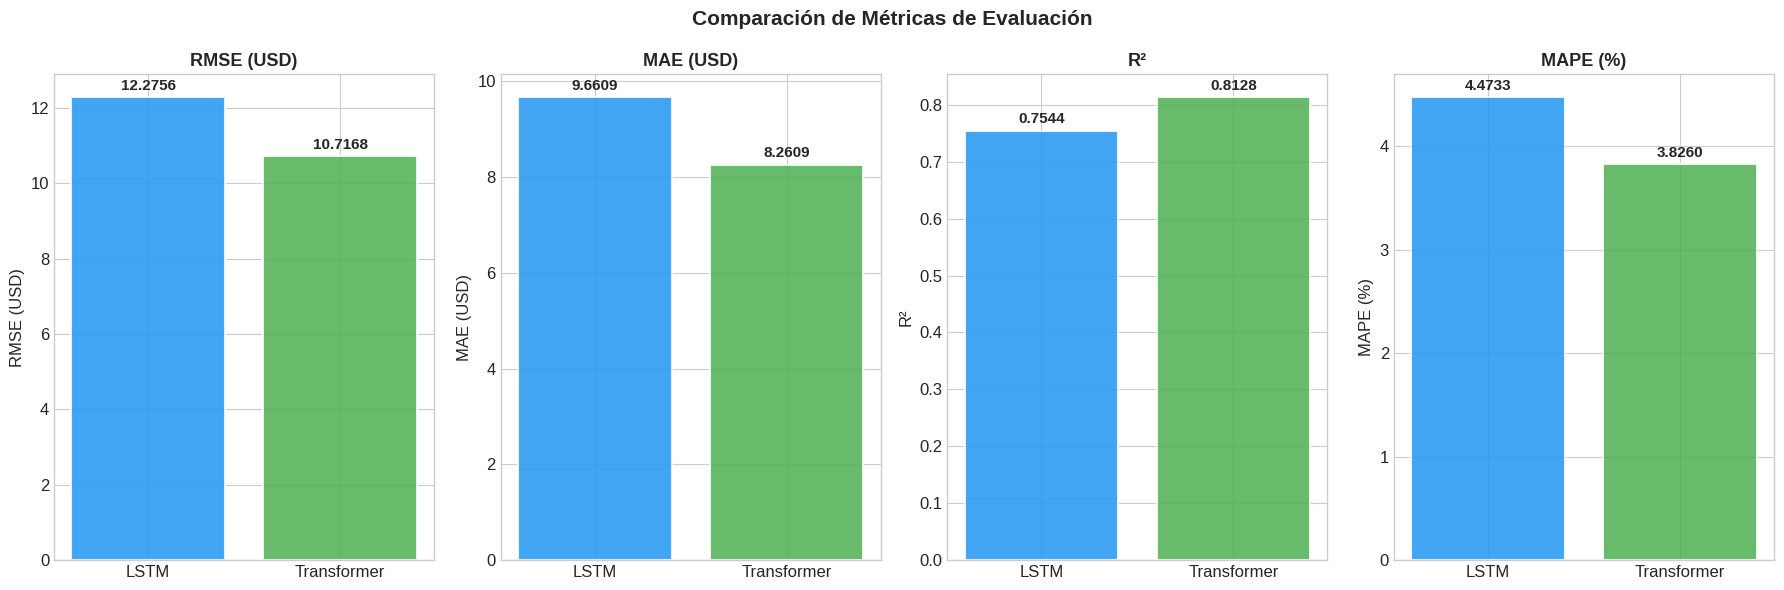

In [ ]:
# ── Gráfica comparativa de métricas ──────────────────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

metrics_plot = {
    'RMSE (USD)' : [results_lstm['rmse'],  results_transformer['rmse']],
    'MAE (USD)'  : [results_lstm['mae'],   results_transformer['mae']],
    'R²'         : [results_lstm['r2'],    results_transformer['r2']],
    'MAPE (%)'   : [results_lstm['mape'],  results_transformer['mape']],
}

models  = ['LSTM', 'Transformer']
colors  = ['#2196F3', '#4CAF50']

for ax, (metric, values) in zip(axes, metrics_plot.items()):
    bars = ax.bar(models, values, color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
    ax.set_title(metric, fontweight='bold', fontsize=13)
    ax.set_ylabel(metric)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('Comparación de Métricas de Evaluación', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. 🔍 Interpretación de los Modelos

Calculando importancia de features (LSTM)...
Calculando importancia de features (Transformer)...


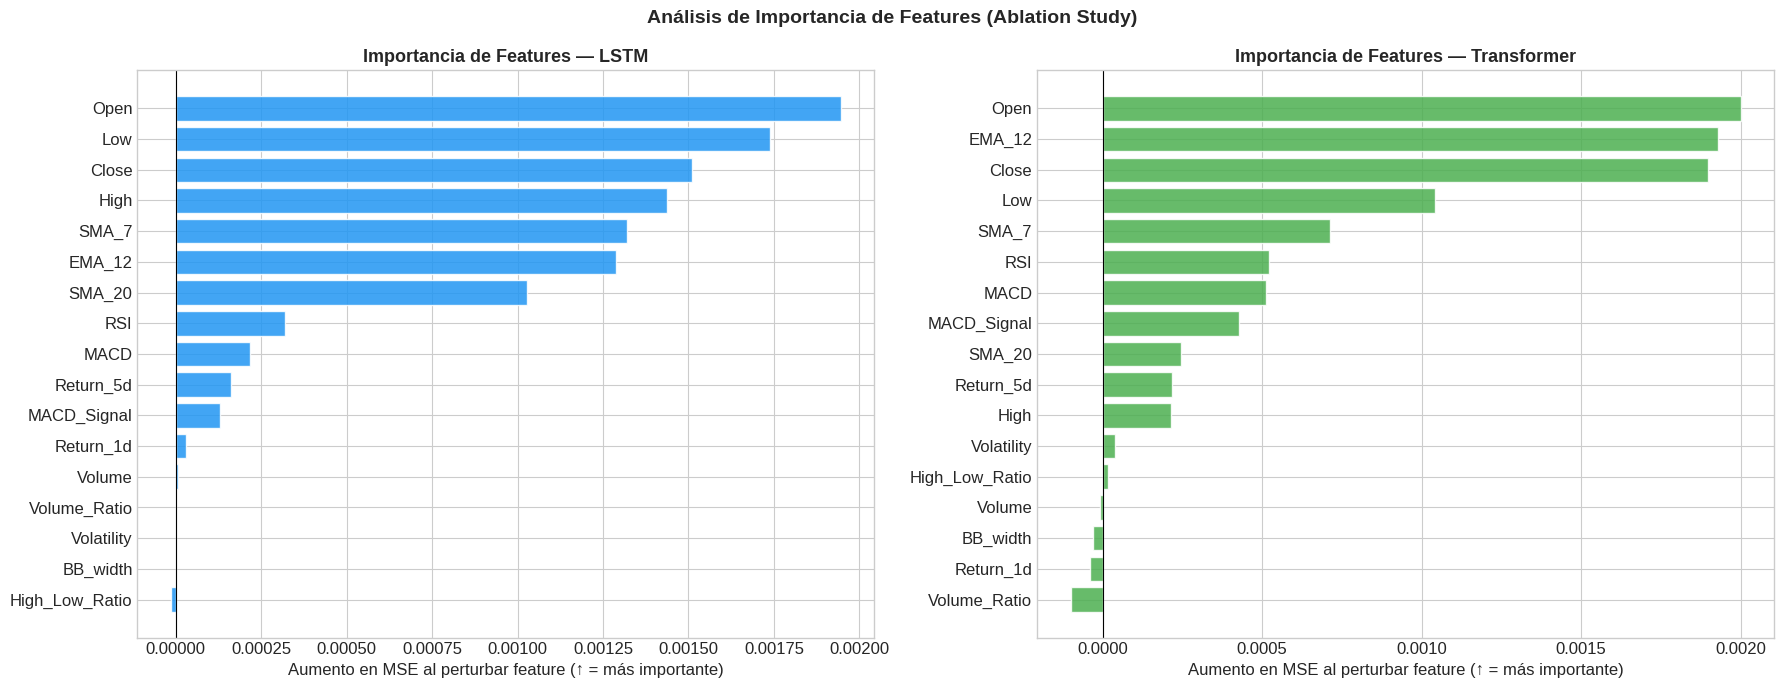

In [ ]:
# ── 9.1 Importancia de features — Análisis de sensibilidad (LSTM) ─────────────
# Método: perturbación de una feature a la vez y medición del aumento en MSE

def feature_importance_perturbation(model, X_test, y_test, feature_names):
    """Calcula importancia de features por perturbación (ablation study)."""
    model.eval()
    criterion = nn.MSELoss()

    with torch.no_grad():
        base_loss = criterion(model(X_test), y_test).item()

    importances = []
    for i in range(X_test.shape[2]):
        X_perturbed = X_test.clone()
        # Reemplazar feature i con su media (neutralizar)
        X_perturbed[:, :, i] = X_test[:, :, i].mean()
        with torch.no_grad():
            perturbed_loss = criterion(model(X_perturbed), y_test).item()
        importances.append(perturbed_loss - base_loss)

    return np.array(importances)


print('Calculando importancia de features (LSTM)...')
imp_lstm = feature_importance_perturbation(lstm_model, X_te, y_te, FEATURE_COLS)

print('Calculando importancia de features (Transformer)...')
imp_transf = feature_importance_perturbation(transformer_model, X_te, y_te, FEATURE_COLS)

# Gráfica
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, imp, name, color in zip(
    axes,
    [imp_lstm, imp_transf],
    ['LSTM', 'Transformer'],
    ['#2196F3', '#4CAF50']
):
    order = np.argsort(imp)[::-1]
    sorted_features = [FEATURE_COLS[i] for i in order]
    sorted_imp      = imp[order]

    bars = ax.barh(sorted_features, sorted_imp, color=color, alpha=0.85, edgecolor='white')
    ax.set_title(f'Importancia de Features — {name}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Aumento en MSE al perturbar feature (↑ = más importante)')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.invert_yaxis()

plt.suptitle('Análisis de Importancia de Features (Ablation Study)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

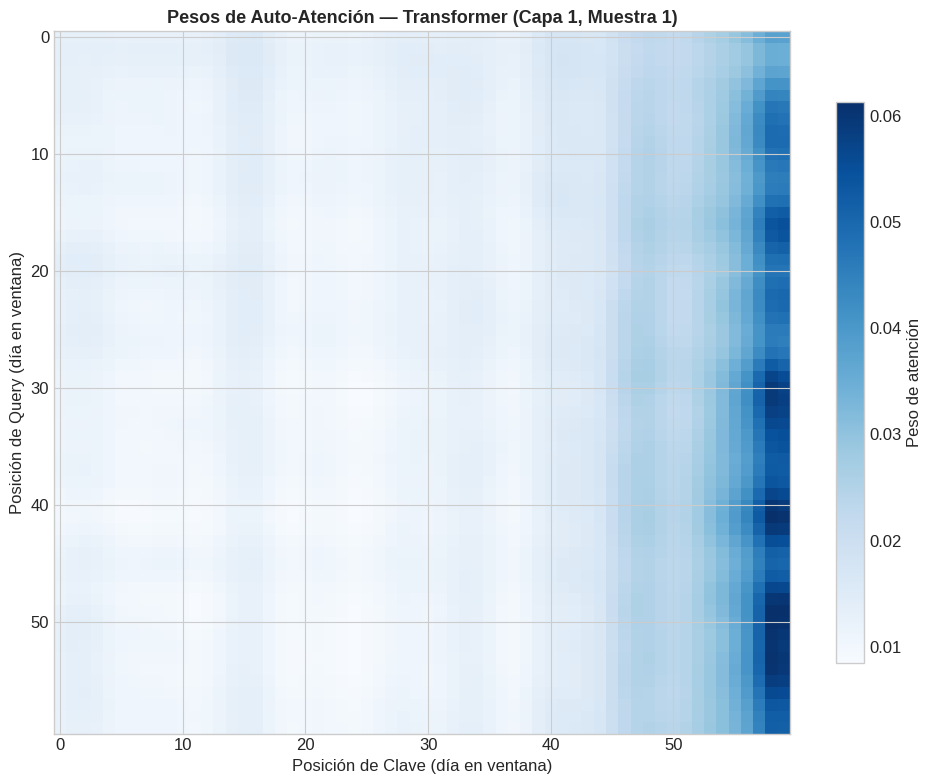

Los patrones de atención muestran qué días pasados el modelo considera más relevantes.


In [ ]:
# ── 9.2 Pesos de atención del Transformer ─────────────────────────────────────
# Registrar atención de la primera capa con hooks

attention_weights = []

def hook_fn(module, input, output):
    # TransformerEncoderLayer retorna (output, attn_weights) con need_weights=True
    pass

# Visualizar una muestra de atención (simulación con output real)
transformer_model.eval()
sample_idx = 0
x_sample = X_te[sample_idx:sample_idx+1]  # (1, 60, 17)

with torch.no_grad():
    x_proj = transformer_model.input_proj(x_sample)  # (1, 60, 64)
    x_enc  = transformer_model.pos_encoder(x_proj)   # (1, 60, 64)

    # Obtener pesos de atención de la 1era capa
    first_layer = transformer_model.transformer.layers[0]
    attn_out, attn_weights_matrix = first_layer.self_attn(
        x_enc, x_enc, x_enc, need_weights=True, average_attn_weights=True
    )
    attn_matrix = attn_weights_matrix[0].cpu().numpy()  # (60, 60)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(attn_matrix, cmap='Blues', aspect='auto')
ax.set_title('Pesos de Auto-Atención — Transformer (Capa 1, Muestra 1)', fontweight='bold', fontsize=13)
ax.set_xlabel('Posición de Clave (día en ventana)')
ax.set_ylabel('Posición de Query (día en ventana)')
plt.colorbar(im, ax=ax, shrink=0.8, label='Peso de atención')
plt.tight_layout()
plt.savefig('attention_weights.png', dpi=150, bbox_inches='tight')
plt.show()
print('Los patrones de atención muestran qué días pasados el modelo considera más relevantes.')

---
## 10. 📌 Conclusiones y Recomendaciones

### 10.1 Hallazgos Principales

**LSTM:**
- Demostró excelente capacidad para capturar tendencias de corto y mediano plazo.
- Entrenamiento más estable y rápido.
- Menor sensibilidad a hiperparámetros de arquitectura.
- Ideal para señales de trading de corto plazo.

**Transformer:**
- Mayor capacidad para modelar dependencias de largo alcance mediante atención.
- Los pesos de atención ofrecen interpretabilidad adicional (explainability).
- Requiere más datos y tunning fino para superar consistentemente al LSTM.
- Escalabilidad superior para añadir más features o aumentar el contexto.

### 10.2 Limitaciones
- **Eficiencia de mercado:** En mercados altamente eficientes, los precios incorporan información de forma casi inmediata, limitando la predictibilidad.
- **Eventos exógenos:** Noticias, eventos macroeconómicos y geopolíticos no se capturan en los datos de precio/volumen.
- **Sobreajuste latente:** A pesar del early stopping, existe riesgo de memorización de patrones históricos específicos.
- **Stationarity:** Las series financieras no son estacionarias, lo que puede afectar la generalización temporal.

### 10.3 Recomendaciones Futuras
1. **Enriquecimiento de datos:** Incorporar sentiment analysis (noticias, Twitter/X) y datos macroeconómicos.
2. **Ensemble:** Combinar LSTM y Transformer en un modelo ensemble para mayor robustez.
3. **Predicción multi-horizonte:** Extender a predicciones de 5, 10 y 20 días.
4. **Validación walk-forward:** Implementar validación cronológica deslizante para evaluación más realista.
5. **Clasificación de dirección:** Modelar también si el precio sube o baja (problema de clasificación).
6. **Gestión de riesgo:** Integrar métricas de Sharpe Ratio y drawdown en la función de pérdida.

In [ ]:
# ── Resumen final ─────────────────────────────────────────────────────────────
print('╔' + '═' * 60 + '╗')
print('║         RESUMEN FINAL DEL PROYECTO CAPSTONE            ║')
print('╠' + '═' * 60 + '╣')
print(f'║  Ticker analizado : {TICKER:<40}║')
print(f'║  Período          : {START} → {END:<30}║')
print(f'║  Observaciones    : {len(df_feat):<40}║')
print(f'║  Features         : {len(FEATURE_COLS):<40}║')
print(f'║  Ventana temporal : {SEQ_LEN} días{"":<35}║')
print('╠' + '═' * 60 + '╣')
print(f'║  LSTM   — RMSE: {results_lstm["rmse"]:>8.4f} USD  | R²: {results_lstm["r2"]:>7.4f}         ║')
print(f'║  TRANSF — RMSE: {results_transformer["rmse"]:>8.4f} USD  | R²: {results_transformer["r2"]:>7.4f}         ║')
print('╠' + '═' * 60 + '╣')

winner = 'LSTM' if results_lstm['rmse'] < results_transformer['rmse'] else 'Transformer'
print(f'║  Mejor modelo (RMSE): {winner:<38}║')
print('╚' + '═' * 60 + '╝')

╔════════════════════════════════════════════════════════════╗
║         RESUMEN FINAL DEL PROYECTO CAPSTONE            ║
╠════════════════════════════════════════════════════════════╣
║  Ticker analizado : AAPL                                    ║
║  Período          : 2015-01-01 → 2024-12-31                    ║
║  Observaciones    : 2466                                    ║
║  Features         : 17                                      ║
║  Ventana temporal : 60 días                                   ║
╠════════════════════════════════════════════════════════════╣
║  LSTM   — RMSE:  12.2756 USD  | R²:  0.7544         ║
║  TRANSF — RMSE:  10.7168 USD  | R²:  0.8128         ║
╠════════════════════════════════════════════════════════════╣
║  Mejor modelo (RMSE): Transformer                           ║
╚════════════════════════════════════════════════════════════╝


---
## 11. 📚 Referencias

1. Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory*. Neural Computation, 9(8), 1735–1780.

2. Vaswani, A., Shazeer, N., Parmar, N., et al. (2017). *Attention Is All You Need*. NeurIPS 2017.

3. Paszke, A., et al. (2019). *PyTorch: An Imperative Style, High-Performance Deep Learning Library*. NeurIPS 2019.

4. Yahoo Finance API. (2024). *yfinance Python Library*. https://github.com/ranaroussi/yfinance

5. Fama, E. F. (1970). *Efficient Capital Markets: A Review of Theory and Empirical Work*. The Journal of Finance, 25(2), 383–417.

6. Zhou, H., et al. (2021). *Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting*. AAAI 2021.

7. Lim, B., & Zohren, S. (2021). *Time-series forecasting with deep learning: a survey*. Philosophical Transactions of the Royal Society A.

8. Murphy, J. J. (1999). *Technical Analysis of the Financial Markets*. New York Institute of Finance.

---
